In [1]:
import sys
sys.path.append(r'C:/Users/ryoo/AppData/Local/gsas2main/GSAS-II')

import GSASII.GSASIIpath as GSASIIpath
GSASIIpath.binaryPath = r'C:/Users/ryoo/AppData/Local/gsas2main/GSAS-II/GSASII-bin/win_64_p3.13_n2.2'
GSASIIpath.SetBinaryPath(True)

import GSASII.GSASIIscriptable as G2sc
from GSASII import GSASIIspc as G2spc
from GSASII import GSASIIlattice as G2lat
from GSASII.GSASIIpwd import getPsVoigt  

import matplotlib.pyplot as plt 
from matplotlib.collections import LineCollection
from matplotlib.legend_handler import HandlerLineCollection
import numpy as np

6 values read from C:\Users\ryoo\.GSASII\config.ini
GSAS-II binary directory: C:\Users\ryoo\AppData\Local\gsas2main\GSAS-II\GSASII-bin\win_64_p3.13_n2.2


In [7]:
def build_phase_pattern(ref_array, x, phase_scale):
    y = np.zeros_like(x, float)
    for row in ref_array:
        tt0 = row[5]
        sig_cd2 = row[6]
        gam_cd  = row[7]

        # Patterns, integrated intensity = GgetPsVoigt()  
        prof = np.asarray(getPsVoigt(tt0, sig_cd2, gam_cd, x)[0], dtype=float)

        # Intensity corection
        Iref = float(row[9] * row[11]) 
        #Iref = Iref*row[12]*row[13]*row[14]
        """ ==> I don't know if this is necessary but 
        [12] == preferred orientation correction, 
        [13] == Transmission (absorption correction)
        [14] == Extinction correction
        
        For explanation
        [0,1,2] == h,k,l indices
        [3] == multimlicity
        [4] == d-spacing
        [5] == pos, two-theta
        [6] == sig Gaussian width (in centidegrees)
        [7] == gam Lorentzian width (in centidegrees)
        [8] == (Fobs)^2
        [9] == (Fcalc)^2
        [10] == Reflection phase in degrees
        [11] intensity correction for reflection, this times [8] or [9] gives the Iobs or Icalc"""

        y += prof * Iref

    # y *= phase_scale
    return y



In [23]:
def plot_refinement_result_subplots_with_phases(
    gpx,
    hist_index=0,
    phase_names=None,          # None이면 이 histogram이 실제로 가진 phase만
    figsize=(12, 12),
    show_bragg_on=('top', 'bottom')
):
    hist = gpx.histogram(hist_index)
    hist_name = hist.name

    # hist.data["data"] 구조에 맞춰서 꺼내기
    data = hist.data["data"]
    x = np.array(data[1][0])
    y_obs = np.array(data[1][1])
    y_calc = np.array(data[1][3])
    y_bkg = np.array(data[1][4])
    y_calc_minus_bkg = y_calc - y_bkg
    # residual이 있으면 쓰고 없으면 obs-calc
    if len(data[1]) > 5:
        y_diff = np.array(data[1][5])
    else:
        y_diff = y_obs - y_calc

    limits = hist.data["Limits"][1]

    # 이 histogram이 실제로 갖고 있는 reflection 키만 쓰기
    refl_all = hist.reflections()
    if phase_names is None:
        phase_names = list(refl_all.keys())
    elif isinstance(phase_names, str):
        phase_names = [phase_names]

    # phase별 패턴 재구성
    phase_patterns = {}
    for pn in phase_names:
        # 혹시라도 phase 이름이 hist.reflections()에 없으면 스킵
        if pn not in refl_all:
            continue

        ref_array = refl_all[pn]["RefList"]
        ph = gpx.phase(pn)
        phase_scale = ph.data["Histograms"][hist_name]["Scale"][0]

        y_phase = build_phase_pattern(ref_array, x, phase_scale)
        phase_patterns[pn] = y_phase

    # 색상
    cmap = cm.get_cmap('tab10', max(1, len(phase_names)))
    phase_colors = {pn: cmap(i % cmap.N) for i, pn in enumerate(phase_names)}

    # figure
    fig, axes = plt.subplots(
        3, 1, figsize=figsize, sharex=True,
        gridspec_kw={'height_ratios': [3, 1, 1]}
    )

    # 1) top panel
    ax1 = axes[0]
    ax1.plot(x, y_obs, 'k.', ms=3, label='Observed')
    ax1.plot(x, y_calc, color='#e63946', lw=1.5, label='Ycalc')
    ax1.plot(x, y_bkg, color='gray', lw=1.0, ls='--', label='Background')
    ax1.plot(x, y_calc_minus_bkg, color='#457b9d', lw=1.0, ls=':', label='Ycalc - Bkg')

    for pn, y_phase in phase_patterns.items():
        ax1.plot(x, y_phase, color=phase_colors[pn], lw=1.1, label=pn)

    ax1.set_xlim(limits[0], limits[1])
    ax1.set_ylabel("Intensity (a.u.)")
    ax1.set_title(f"{hist_name} | phase-decomposed")
    ax1.grid(True, alpha=0.3)
    # 중복 라벨 제거
    h, l = ax1.get_legend_handles_labels()
    uniq = dict(zip(l, h))
    ax1.legend(uniq.values(), uniq.keys(), fontsize=8, ncol=2, frameon=False)

    # 2) diff
    ax2 = axes[1]
    ax2.plot(x, y_diff, color="#2a9d8f", lw=1.0)
    ax2.axhline(0, color='black', lw=0.5)
    ax2.set_ylabel("Diff")
    ax2.grid(True, alpha=0.3)

    # 4) Bragg positions
    ax3 = axes[2]
    drew_any = False
    for pn in phase_names:
        if pn not in refl_all:
            continue
        ref_array = refl_all[pn]["RefList"]
        pos = [row[5] for row in ref_array if limits[0] <= row[5] <= limits[1]]
        if not pos:
            continue
        ax3.vlines(pos, -0.4, 0.4, color=phase_colors[pn], lw=1.3, label=pn)
        drew_any = True

    if drew_any:
        ax3.legend(fontsize=8, ncol=2, frameon=False)
    else:
        ax3.text(0.5, 0.5, "No Bragg peaks", ha='center', va='center', transform=ax3.transAxes)

    ax3.set_ylim(-0.5, 0.5)
    ax3.set_yticks([])
    ax3.set_xlabel("2θ (deg)")
    ax3.set_xlim(limits[0], limits[1])
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    return fig, axes

In [28]:
def plot_diff_ycalc_minus_phases(gpx, hist_index=0):
    """(Ycalc - Background) - (Σ phase patterns) 차이만 단독으로 표시"""
    hist = gpx.histogram(hist_index)
    hist_name = hist.name

    # --- 데이터 불러오기 ---
    data = hist.data["data"]
    x = np.array(data[1][0])
    ycalc = np.array(data[1][3])
    ybkg = np.array(data[1][4])
    ycalc_minus_bkg = ycalc - ybkg
    limits = hist.data["Limits"][1]

    refl_all = hist.reflections()
    phase_names = list(refl_all.keys())

    # --- 각 phase별 패턴 ---
    y_total = np.zeros_like(x, float)
    for pn in phase_names:
        ref_array = refl_all[pn]["RefList"]
        ph = gpx.phase(pn)
        hist_name = hist.name
        phase_scale = ph.data["Histograms"][hist_name]["Scale"][0]
        y_phase = build_phase_pattern(ref_array, x, phase_scale)
        y_total += y_phase

    # --- 차이 계산 ---
    diff_custom = ycalc_minus_bkg - y_total

    # --- 플롯 ---
    plt.figure(figsize=(8, 4))
    plt.plot(x, diff_custom, color='#1d3557', lw=1.3, label='(Ycalc - Background) - Σphases')
    plt.axhline(0, color='black', lw=0.6)
    plt.xlim(limits[0], limits[1])
    plt.xlabel("2θ (°)", fontsize=12)
    plt.ylabel("Residual Intensity", fontsize=12)
    plt.title(f"{hist_name} | (Ycalc - Bkg) - (Σ phase patterns)")
    plt.legend(frameon=False)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [4]:
## Need to load the file again before running refinement 
gpx = G2sc.G2Project("C:/Users/ryoo/Desktop/LDRD/Code/XRD_processing/Test/test.gpx")
hist = gpx.histogram(0)

# # 이제 refinement 실행
refdict = {
    'histograms': [hist]
}
gpx.do_refinements([refdict])
gpx.save()

gpx file saved as C:\Users\ryoo\Desktop\LDRD\Code\XRD_processing\Test\test.gpx
 Hessian Levenberg-Marquardt SVD refinement on 8 variables:
initial chi^2 1.0483e+05 with 344 obs.
divergence: chi^2 1.8568e+07 on 344 obs. (4 SVD zeros)
	increasing Marquardt lambda to 1.0e-03
divergence: chi^2 1.8565e+07 on 344 obs. (0 SVD zeros)
	increasing Marquardt lambda to 1.0e-02
divergence: chi^2 1.8612e+07 on 344 obs. (0 SVD zeros)
	increasing Marquardt lambda to 1.0e-01
divergence: chi^2 1.522e+07 on 344 obs. (0 SVD zeros)
	increasing Marquardt lambda to 1.0e+00
divergence: chi^2 3.7735e+06 on 344 obs. (0 SVD zeros)
	increasing Marquardt lambda to 1.0e+01
Cycle 0: 0.12s, Chi**2: 1.0357e+05 for 344 obs., Lambda: 10,  Delta: 0.0121, SVD=0
Cycle 1: 0.01s, Chi**2: 99069 for 344 obs., Lambda: 10,  Delta: 0.0434, SVD=0
Cycle 2: 0.01s, Chi**2: 98325 for 344 obs., Lambda: 10,  Delta: 0.00751, SVD=0
Maximum shift/esd = 19.545 for all cycles
SVD problem(s) likely from:
  0::A1, 0::A2, 1::A2, :0:Scale
Note h

C:\Users\ryoo\AppData\Local\Temp\1\ipykernel_43508\3352223274.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', max(1, len(phase_names)))


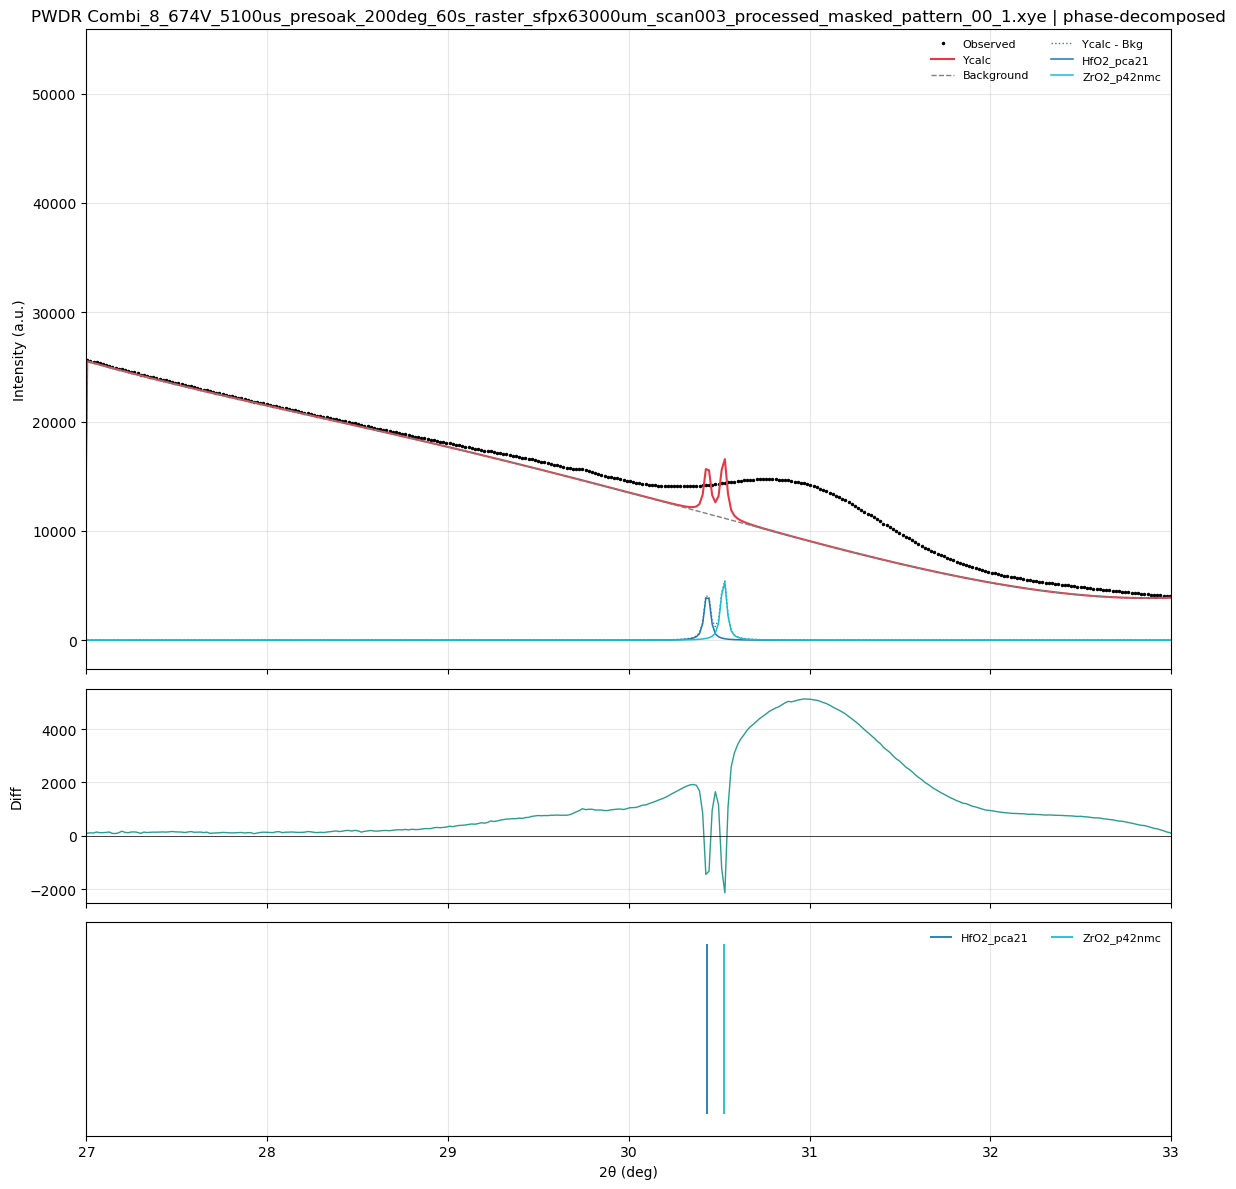

(<Figure size 1200x1200 with 3 Axes>,
 array([<Axes: title={'center': 'PWDR Combi_8_674V_5100us_presoak_200deg_60s_raster_sfpx63000um_scan003_processed_masked_pattern_00_1.xye | phase-decomposed'}, ylabel='Intensity (a.u.)'>,
        <Axes: ylabel='Diff'>, <Axes: xlabel='2θ (deg)'>], dtype=object))

In [24]:
plot_refinement_result_subplots_with_phases(
    gpx,
    hist_index=0,
    phase_names=None,          # None이면 이 histogram이 실제로 가진 phase만
    figsize=(12, 12),
    show_bragg_on=('top', 'bottom')
)

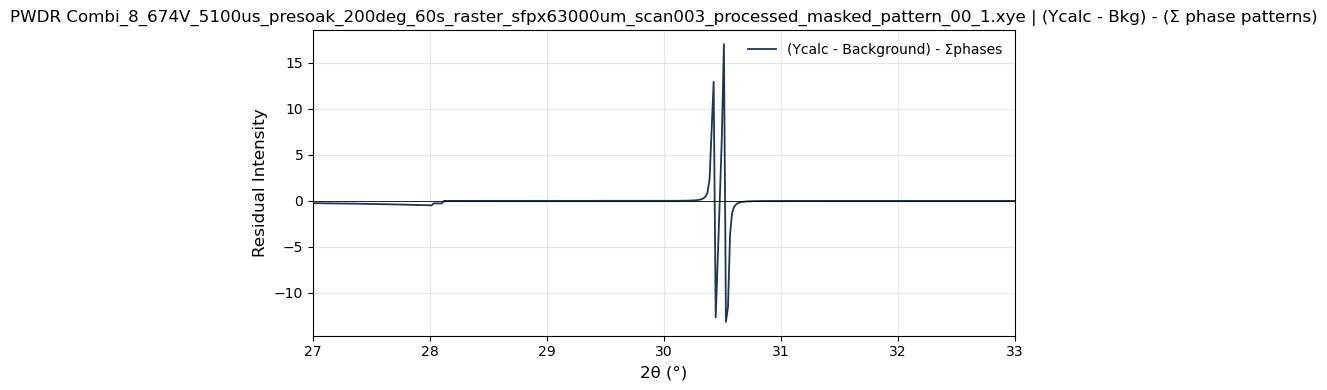

In [27]:
plot_diff_ycalc_minus_phases(gpx, hist_index=0)